## Analysis of the OBS WikiHouse beams
The code does the following:
1) it loads the experimental data of the test done at Imperial
2) It cleans the data by removing the initial offsets (if needed)
3) It finds parameters of interest such peak force, stiffness etc
4) it plots the data and saves the figures

### Data loading and cleaning

In [1]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Define the classes

In [2]:
# create a class object for the single test
class Structural_test():
    def __init__(self,test_label,data_raw,data_raw_path):
        self.data_raw=data_raw; # assign the raw data
        self.data_raw_path=data_raw_path; # assign the data raw path
        self.test_label=test_label; # assign the test label
    
    def remove_offset(self,channel_indices):
        self.data_offset_removed=self.data_raw.copy(); # initialize the dataset;
        for i in channel_indices:
            self.data_offset_removed.iloc[:,i]=self.data_offset_removed.iloc[:,i]-self.data_offset_removed.iloc[0,i]; # offset the initial values
        return self.data_offset_removed;
    
    # this method interpolate the values of the actuator between force value F_1 and force value F_2
    def adjust_pump(self,force_header,F_1,F_2):
        Forces=self.data_offset_removed[force_header].copy(); # extract the force time series
        i_F1=next(x[0] for x in enumerate(Forces) if x[1] >= F_1); # find the indeces correspnding to  F_1 and assign it
        i_F2=next(x[0] for x in enumerate(Forces) if x[1] >= F_2); # find the indeces correspnding to  F_2 and assign it
        Forces[i_F1:i_F2]=np.nan; # subsitute the np.nan values
        self.data_offset_removed[force_header]=Forces.interpolate();
    
    def find_maxF_and_stiffness(self,data,force_header,displacement_header):
        self.i_F_max=np.argmax(data[force_header]); # find the index corresponding to the max value of force and assign it
        self.F_max=data[force_header][self.i_F_max]; # find the max force value  and assign it
        self.d_max=data[displacement_header][self.i_F_max]; # find the displacement corresponding to the max force value  and assign it     
        F_10=0.1*self.F_max; # calculate 10% of the max force
        F_40=0.4*self.F_max; # calculate 40% of the max force
        self.i_10=next(x[0] for x in enumerate(data[force_header]) if x[1] >= F_10); # find the indeces correspnding to  F_10 and assign it
        self.i_40=next(x[0] for x in enumerate(data[force_header]) if x[1] >= F_40); # find the indeces correspnding to  F_40 and assign it
        self.d_10=data[displacement_header][self.i_10]; # displacement value corresponding to i_10 index
        self.F_10=data[force_header][self.i_10]; # force value corresponding to i_10 index
        self.d_40=data[displacement_header][self.i_40]; # displacement value corresponding to i_40 index
        self.F_40=data[force_header][self.i_40]; # force value corresponding to i_40 index
        self.stiffness=(self.F_40-self.F_10)/(self.d_40-self.d_10); # calculate teh elastic stiffness bewtween the 40% and 10% points
        self.slip_modulus=self.F_40/(4/3*(self.d_40-self.d_10)); # calculate the slip modulus
        
    def extract_deflected_shape(self,data,potentiomer_headers,force_header,force_values):
        deflected_shape=[]; # initialize the list
        deflected_shape_forces=[]; # initialize the list
        
        for force in force_values:
            i_F=next(x[0] for x in enumerate(data[force_header]) if x[1] >= force); # find the indeces correspnding to  force and assign it
            deflected_shape.append(data.loc[i_F,potentiomer_headers].to_list()); # extract the values corresponding to i_F into a list
            deflected_shape_forces.append(force); # append the actual force
        
        self.deflected_shape=deflected_shape; # save the variables
        self.deflected_shape_forces=deflected_shape_forces; # save the variables    
        
        
        

### Load the data

In [3]:
# Load the raw data
input_file_paths=["S/S_1.CSV"]; # strucutre of the input file
test_labels=["S_1"]; # labels for the tests
Channels_of_interest=[1,2,3,4,5,6,7,8,9]; # only load these channels from the file
header_names=['Force (kN)','Disp_actuator (mm)','Pot_4 (mm)','Pot_5 (mm)','Pot_6 (mm)','Pot_7 (mm)','Pot_8 (mm)','Pot_9 (mm)','Pot_10 (mm)',]; # headers and units of each experimental channel
experiment_dictionary={}; # create the empty dictionary

for i,(data_path,label) in enumerate(zip(input_file_paths,test_labels)):
    data_raw=pd.read_table(data_path,sep=',',skiprows=1,usecols=Channels_of_interest,names=header_names); # read the data
    test=Structural_test(label,data_raw,data_path); # create the structural test object and add the raw data
    experiment_dictionary[label]=test; # add the data to the dictionary


### Data analysis
The followings operations are made:
1) Data are offset with respect to their initial value
2) Max force, stiffness and slip modulus are calculated by simple math operations.

In [4]:
# Data analysis 
force_header='Force (kN)'; # extract the header associated to forces
displacement_header='Pot_7 (mm)'; # extract the header associated to displacements

for test in experiment_dictionary.values():
    test.remove_offset(range(len(header_names))); # remove offsets on all channels
    if test.test_label=='S_1':
        test.adjust_pump(force_header,F_1=3.7,F_2=7.7);
        
    test.find_maxF_and_stiffness(data=test.data_offset_removed,force_header=force_header,displacement_header=displacement_header); # find the max force and stiffness by passing the column correscponding to force and the column corresponding to displacement


### Data plotting
Plot the data and generate meaningful visualizations

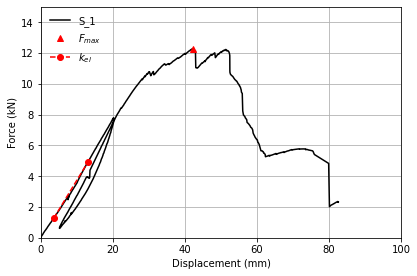

In [5]:
# Plot the force displacement 
output_folder="Figures/";
x_label_plot='Displacement (mm)'; # labelling of the x axis
y_label_plot='Force (kN)'; # labelling of the y axis
fig_h=10; # fig height in cm
fig_w=15; # fig with in cm
x_lim_plot=[0,100]; # limits in the plot
y_lim_plot=[0,15]; # limits in the plot

test_to_plot='S_1'; # name of the test to plot
fig,ax=plt.subplots()
ax.plot(test.data_offset_removed[displacement_header],test.data_offset_removed[force_header],color='k',linestyle='-',label=test.test_label)
ax.plot(test.d_max,test.F_max,'r^',label=r'$F_{max}$')
ax.plot([test.d_10,test.d_40],[test.F_10,test.F_40],'ro--',label=r'$k_{el}$')

ax.grid()
ax.legend(loc="upper left",framealpha=0.0)
ax.set_xlim(x_lim_plot)
ax.set_ylim(y_lim_plot)
ax.set_xlabel(x_label_plot)
ax.set_ylabel(y_label_plot)
fig.set_size_inches(fig_w/2.54,fig_h/2.54)
fig.tight_layout()
name=output_folder+'S_1.png'
fig.savefig(name,dpi=400)   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


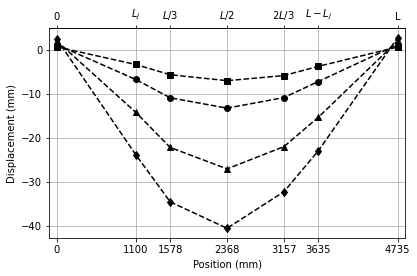

In [12]:
# plot the deflected shape
force_values_to_plot=[2.5,5,10,12]; # force values to plot the deflected shape
test_to_plot='S_1'; # name of the test to plot
test=experiment_dictionary[test_to_plot]; # retrieve the test data
potentiometer_headers=header_names[2:9]; # retrieve only from Pot 5 to pot 9
test.extract_deflected_shape(data=test.data_offset_removed,
                             potentiomer_headers=potentiometer_headers,
                             force_header=force_header
                             ,force_values=force_values_to_plot); # extract the deflected shape
potentiometers_location_numeric=[0,1100,1578.33,2367.5,3156.67,3635,4735]; # location of the potentiometers in numbers
potentiometers_location_labels=[0,r'$L_j$',r'$L/3$',r'$L/2$',r'$2L/3$',r'$L-L_j$','L']
color_list=['k']*4;
line_list=['--']*4;
symbol_list=['s','o','^','d'];
fig,ax=plt.subplots()
for shape,c,l,s in zip(test.deflected_shape,color_list,line_list,symbol_list):  
    ax.plot(potentiometers_location_numeric,-np.array(shape),c+l+s)

x_delta_plot=100;
ax.grid()
ax.legend(loc="upper left",framealpha=0.0)
ax.set_xlim([potentiometers_location_numeric[0]-x_delta_plot,potentiometers_location_numeric[-1]+x_delta_plot])
ax.set_xticks(potentiometers_location_numeric)

secax = ax.secondary_xaxis('top')
secax.set_xticks(potentiometers_location_numeric)
secax.set_xticklabels(potentiometers_location_labels)

# ax.set_ylim(y_lim_plot)
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Displacement (mm)')
fig.set_size_inches(fig_w/2.54,fig_h/2.54)
fig.tight_layout()
name=output_folder+'deflected_shape.png'
fig.savefig(name,dpi=400)   



In [126]:
test.stiffness

0.3850656231063749

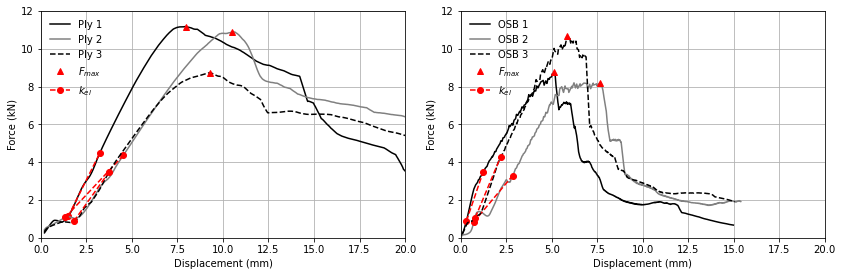

In [5]:
# output_folder="Figures/";
# x_label_plot='Displacement (mm)'; # labelling of the x axis
# y_label_plot='Force (kN)'; # labelling of the y axis
# fig_h=10; # fig height in cm
# fig_w=30; # fig with in cm
# x_lim_plot=[0,20]; # limits in the plot
# y_lim_plot=[0,12]; # limits in the plot
# fig,ax=plt.subplots(1,2)
# displacement_header=header_names[2]; # extract the header associated to displacements
# force_header=header_names[1]; # extract the header associated to forces
# color_list=['k','grey','k']*3;
# line_list=['-','-','--']*3;
# for i,(test,c,l) in enumerate(zip(experiment_dictionary.values(),color_list,line_list)):
#     if i<=2:
#         ax[0].plot(test.data_clean[displacement_header],test.data_clean[force_header],color=c,linestyle=l,label=test.test_label)
#         if i==2:
#             ax[0].plot(test.d_max,test.F_max,'r^',label=r'$F_{max}$')
#             ax[0].plot([test.d_10,test.d_40],[test.F_10,test.F_40],'ro--',label=r'$k_{el}$')
#         else:
#             ax[0].plot(test.d_max,test.F_max,'r^')
#             ax[0].plot([test.d_10,test.d_40],[test.F_10,test.F_40],'ro--')
#     if i>2:
#         ax[1].plot(test.data_clean[displacement_header],test.data_clean[force_header],color=c,linestyle=l,label=test.test_label)
#         if i==5:
#             ax[1].plot(test.d_max,test.F_max,'r^',label=r'$F_{max}$')
#             ax[1].plot([test.d_10,test.d_40],[test.F_10,test.F_40],'ro--',label=r'$k_{el}$')
#         else:
#             ax[1].plot(test.d_max,test.F_max,'r^')
#             ax[1].plot([test.d_10,test.d_40],[test.F_10,test.F_40],'ro--')
        
# for axes in ax:
#     axes.grid()
#     axes.legend(loc="upper left",framealpha=0.0)
#     axes.set_xlim(x_lim_plot)
#     axes.set_ylim(y_lim_plot)
#     axes.set_xlabel(x_label_plot)
#     axes.set_ylabel(y_label_plot)
# fig.set_size_inches(fig_w/2.54,fig_h/2.54)
# fig.tight_layout()
# name=output_folder+'finger_joint_fd.png'
# fig.savefig(name,dpi=400)   